In [ ]:
# Install ydata-profiling (only needs to be run once)
!pip install -q ydata-profiling

import pandas as pd
from ydata_profiling import ProfileReport

# Load the dataset (update the path as needed)
df = pd.read_excel("/content/stock_risk_prediction_dataset (1).xlsx")

# Drop any missing values (optional, based on earlier steps)
df.dropna(inplace=True)

# Generate profiling report
profile = ProfileReport(df, title="Inventory Risk - Original Dataset EDA", explorative=True)

# Save to HTML
profile.to_file("original_data_eda_report.html")

In [ ]:
# 1. Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# 2. Load and Inspect Data
df = pd.read_excel("stock_risk_prediction_dataset (1).xlsx")  # Change file name

print(df.head())
print(df.info())
print(df['stock_status'].value_counts())  # Replace with your actual target column


   current_stock  avg_daily_demand  lead_time_days  reorder_point  \
0            549             45.76            5.64         342.83   
1            486             45.47            6.39         348.37   
2            564             32.04            5.81         353.21   
3            652             46.70            7.22         397.34   
4            476             57.33            9.39         312.64   

   sales_last_30_days  stock_turnover_ratio  forecast_error    season  \
0             1604.49                  4.17           -9.90      peak   
1             1585.00                  4.01           -5.27      peak   
2             1219.04                  3.57           -2.94  off-peak   
3             1673.88                  4.00            0.75  off-peak   
4             1052.98                  4.49            5.12      peak   

   item_category supplier_reliability stock_status  
0      essential                  low    overstock  
1  non-essential                 high   

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title('Target Class Distribution (stock_status)')
plt.show()

In [ ]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# Count plots for categorical features
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='season', hue='stock_status')
plt.title('Season vs Stock Status')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='supplier_reliability', hue='stock_status')
plt.title('Supplier Reliability vs Stock Status')
plt.show()

In [ ]:
# Feature importance
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=importances.index)
plt.title("Feature Importances - Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

In [ ]:
# Drop duplicate rows
df = df.drop_duplicates()
# Strip spaces and fix categorical issues
df.columns = df.columns.str.strip()
for col in df.select_dtypes(include='object'):
    df[col] = df[col].str.strip()

In [ ]:
# Numerical features vs target
for col in df.select_dtypes(include='number').columns:
    if col != 'stock_status':  # skip target
        plt.figure(figsize=(6,4))
        sns.boxplot(x='stock_status', y=col, data=df)
        plt.title(f'{col} vs Stock Status')
        plt.tight_layout()
        plt.show()

# Categorical vs target
for col in df.select_dtypes(include='object').columns:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x=col, hue='stock_status')
    plt.title(f'{col} by Stock Status')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
# Define columns safe to clean
columns_to_clean = ['current_stock', 'avg_daily_demand', 'stock_turnover_ratio', 'sales_last_30_days']

# Create a copy
df_clean = df.copy()

# Remove outliers using IQR method
for col in columns_to_clean:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]

# Check if both classes are still present
print(df_clean['stock_status'].value_counts())

In [ ]:
sns.countplot(data=df, x='stock_status')
plt.title("Class Distribution")
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(df_clean.select_dtypes(include='number').corr(),
            annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap (After Outlier Removal)")
plt.tight_layout()
plt.show()

In [ ]:
# 3. Define features and target
X = df.drop(columns=['stock_status'])  # Replace with actual column name
y = df['stock_status']


In [ ]:
# 4. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:
# 5. Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC(probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier()
}

In [ ]:
# 6. Function to train and evaluate each model using pipeline
results = []

# Import necessary encoders
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

# Identify categorical columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

# Create a preprocessor to handle categorical and numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # Keep numerical columns as they are
)

# Initialize LabelEncoder for the target variable
label_encoder = LabelEncoder()

# Fit and transform the target variable into numerical labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test) # Use the same encoder for test set

for name, model in models.items():
    # Update the pipeline to include the preprocessor before SMOTE and scaling
    pipe = ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('scaler', StandardScaler()),
        ('clf', model)
    ])

    # Fit the pipeline using the encoded target variable
    pipe.fit(X_train, y_train_encoded)
    y_pred_encoded = pipe.predict(X_test)

    # Decode the predictions back to original labels for report
    y_pred = label_encoder.inverse_transform(y_pred_encoded)


    # Ensure y_proba is calculated correctly after preprocessing and SMOTE
    if hasattr(pipe, 'predict_proba'):
         y_proba = pipe.predict_proba(X_test)[:, 1]
    else:

         y_proba = y_pred_encoded # Use encoded predictions for AUC if no proba

    acc = accuracy_score(y_test_encoded, y_pred_encoded)
    auc = roc_auc_score(y_test_encoded, y_proba)


    print(f"\n{name}")
    print("Accuracy:", round(acc, 3))
    print("AUC Score:", round(auc, 3))
    # Use original y_test and decoded y_pred for the classification report for readability
    print(classification_report(y_test, y_pred))


    results.append({'Model': name, 'Accuracy': acc, 'AUC': auc})


Logistic Regression
Accuracy: 0.982
AUC Score: 1.0
              precision    recall  f1-score   support

   overstock       1.00      0.98      0.99       909
    stockout       0.83      1.00      0.91        91

    accuracy                           0.98      1000
   macro avg       0.92      0.99      0.95      1000
weighted avg       0.98      0.98      0.98      1000


Decision Tree
Accuracy: 0.985
AUC Score: 0.957
              precision    recall  f1-score   support

   overstock       0.99      0.99      0.99       909
    stockout       0.91      0.92      0.92        91

    accuracy                           0.98      1000
   macro avg       0.95      0.96      0.95      1000
weighted avg       0.99      0.98      0.99      1000


Random Forest
Accuracy: 0.987
AUC Score: 0.997
              precision    recall  f1-score   support

   overstock       0.99      0.99      0.99       909
    stockout       0.92      0.93      0.93        91

    accuracy                      

                 Model  Accuracy       AUC
0  Logistic Regression     0.982  0.999964
5              XGBoost     0.991  0.999105
3    Gradient Boosting     0.991  0.998634
2        Random Forest     0.987  0.997346
4                  SVM     0.977  0.995733
6          Naive Bayes     0.939  0.984586
1        Decision Tree     0.985  0.957138
7                  KNN     0.921  0.916023


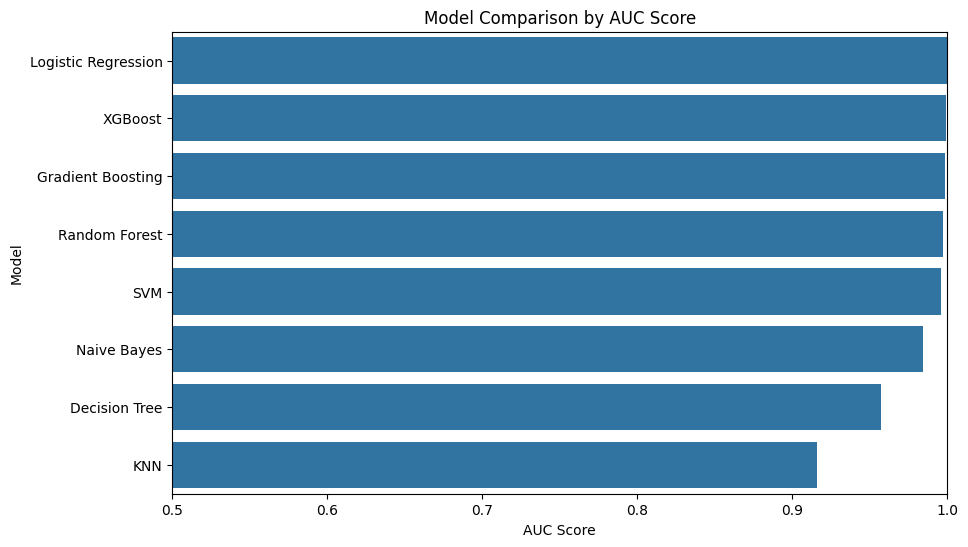

In [ ]:
# 7. Compare Models
results_df = pd.DataFrame(results).sort_values(by='AUC', ascending=False)
print(results_df)

# Plot comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='AUC', y='Model', data=results_df)
plt.title("Model Comparison by AUC Score")
plt.xlabel("AUC Score")
plt.ylabel("Model")
plt.xlim(0.5, 1.0)
plt.show()


Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7241 - loss: 58.9846 - val_accuracy: 0.9125 - val_loss: 11.0125
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8411 - loss: 14.0049 - val_accuracy: 0.9125 - val_loss: 2.9574
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8640 - loss: 5.9424 - val_accuracy: 0.9125 - val_loss: 1.2683
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8656 - loss: 2.8774 - val_accuracy: 0.9125 - val_loss: 0.2913
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9040 - loss: 1.2005 - val_accuracy: 0.9125 - val_loss: 0.2322
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8854 - loss: 1.1970 - val_accuracy: 0.9125 - val_loss: 0.2938
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9036 - loss: 0.7832 - val_accuracy: 0.9125 - val_loss: 0.2615
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9071 - loss: 0.5627 - val_accuracy:

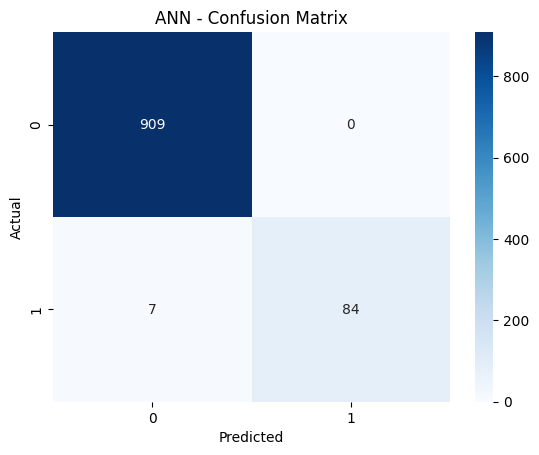

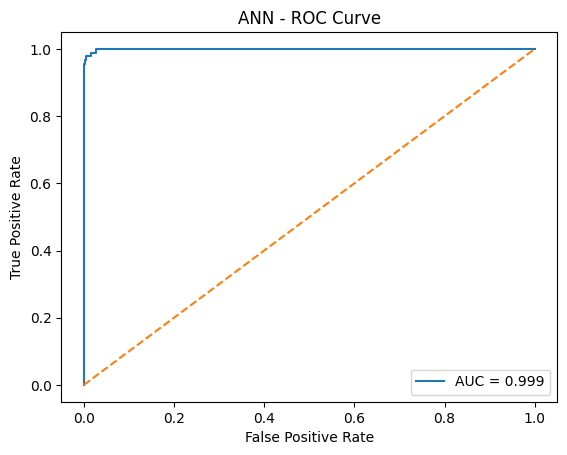

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
# Assuming 'preprocessor', 'y_train_encoded', and 'y_test_encoded' are already defined and fitted from previous cells

# Apply the preprocessor to the training and testing data
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Build the ANN model
# The input_dim should be the number of features after preprocessing
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X_train_processed.shape[1]))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # binary classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model using the processed data and encoded target
history = model.fit(X_train_processed, y_train_encoded, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Predict probabilities and classes using the processed test data
y_pred_proba = model.predict(X_test_processed).ravel()
y_pred_encoded = (y_pred_proba > 0.5).astype(int)

# Decode the predictions back to original labels for report
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Classification Report - Use original y_test and decoded y_pred for readability
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix - Use original y_test and decoded y_pred for readability
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('ANN - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve - Use encoded y_test and predicted probabilities
fpr, tpr, _ = roc_curve(y_test_encoded, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ANN - ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
print(y.value_counts())

stock_status
overstock    4543
stockout      457
Name: count, dtype: int64


📊 Selected Features:
current_stock                  0.627353
reorder_point                  0.230147
avg_daily_demand               0.028267
sales_last_30_days             0.027836
stock_turnover_ratio           0.025950
lead_time_days                 0.025869
forecast_error                 0.024413
season_peak                    0.003673
supplier_reliability_low       0.003354
item_category_non-essential    0.003139
dtype: float64


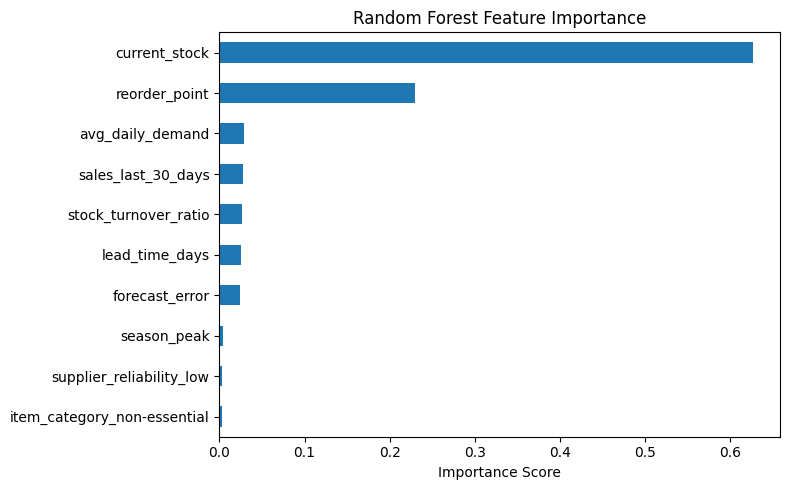

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
df = pd.read_excel("stock_risk_prediction_dataset (1).xlsx")

# The actual target column name is 'stock_status'
target_column = 'stock_status'

# Drop rows where the target column is NaN (if any)
# Use the correct target column name
df = df.dropna(subset=[target_column])

# Encode target
le = LabelEncoder()
# Use the correct target column name for encoding
df[target_column] = le.fit_transform(df[target_column])  # stockout=1, overstock=0 (assuming these are the classes)

# One-hot encode categorical features 'season' and 'item_category'
# Ensure these columns exist before one-hot encoding
if 'season' in df.columns:
    df = pd.get_dummies(df, columns=['season'], prefix='season', drop_first=True)
if 'item_category' in df.columns:
    df = pd.get_dummies(df, columns=['item_category'], prefix='item_category', drop_first=True)
# Based on previous cells, 'supplier_reliability' might also be categorical
if 'supplier_reliability' in df.columns:
    df = pd.get_dummies(df, columns=['supplier_reliability'], prefix='supplier_reliability', drop_first=True)


# Split X and y
# Use the correct target column name
X = df.drop(columns=[target_column])
y = df[target_column]

# 1. Remove low-variance features
# Ensure that X has columns before applying VarianceThreshold
if X.shape[1] > 0:
    selector = VarianceThreshold(threshold=0.01)  # Adjust threshold as needed
    X_var = selector.fit_transform(X)
    selected_var_features = X.columns[selector.get_support()]
else:
    selected_var_features = X.columns # No features to filter

# 2. Remove highly correlated features
# Only proceed if there are features left after variance threshold
if len(selected_var_features) > 1:
    X_corr = X[selected_var_features].copy()
    corr_matrix = X_corr.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
    X_uncorrelated = X_corr.drop(columns=to_drop)
else:
     X_uncorrelated = X[selected_var_features] # Not enough features to check correlation

# 3. Feature importance (Random Forest)
# Only fit Random Forest if there are features left
if X_uncorrelated.shape[1] > 0:
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_uncorrelated, y)
    importances = pd.Series(rf.feature_importances_, index=X_uncorrelated.columns)
    top_features = importances.sort_values(ascending=False)

    # Display top features
    print("📊 Selected Features:")
    print(top_features)

    # Optional: plot
    plt.figure(figsize=(8, 5))
    top_features.plot(kind='barh')
    plt.title("Random Forest Feature Importance")
    plt.xlabel("Importance Score")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print("No features remaining after preprocessing and filtering.")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from tensorflow.keras import Sequential,Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import joblib

# Load dataset
df = pd.read_excel("stock_risk_prediction_dataset (1).xlsx")

# Fix forecast_error if negative
df['forecast_error'] = df['forecast_error'].abs()

# Ensure target column is correct
df['stock_status'] = df['stock_status'].map({'overstock': 0, 'stockout': 1})

# Top 7 features from your feature importance
features = [
    'current_stock', 'reorder_point', 'avg_daily_demand',
    'sales_last_30_days', 'stock_turnover_ratio',
    'lead_time_days', 'forecast_error'
]

X = df[features]
y = df['stock_status']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE after scaling
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train_scaled, y_train)

# Build ANN
model = Sequential([
    Input(shape=(7,)),
    Dense(32, input_dim=7, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(X_train_bal, y_train_bal,
          validation_split=0.2,
          epochs=100,
          batch_size=32,
          callbacks=[early_stop],
          verbose=1)

# Save as TensorFlow SavedModel (not .h5)
model.save("inventory_ann_top7_model.keras")
joblib.dump(scaler, "scaler_top7.pkl")


Epoch 1/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7483 - loss: 0.5440 - val_accuracy: 0.9862 - val_loss: 0.1720
Epoch 2/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9576 - loss: 0.1359 - val_accuracy: 0.9890 - val_loss: 0.0897
Epoch 3/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9718 - loss: 0.0831 - val_accuracy: 0.9945 - val_loss: 0.0541
Epoch 4/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9759 - loss: 0.0608 - val_accuracy: 0.9952 - val_loss: 0.0469
Epoch 5/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9797 - loss: 0.0531 - val_accuracy: 0.9972 - val_loss: 0.0367
Epoch 6/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9846 - loss: 0.0430 - val_accuracy: 0.9972 - val_loss: 0.0302
Epoch 7/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9897 - loss: 0.0348 - val_accuracy: 0.9993 - val_loss: 0.0262
Epoch 8/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9918 - loss: 0.0271 - val_accu

['scaler_top7.pkl']

In [ ]:
sample = np.array([[300, 100, 15, 500, 2.0, 5, 0.1]])  # 7 values
sample_scaled = scaler.transform(sample)
model.predict(sample_scaled)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


array([[1.4689984e-11]], dtype=float32)